# Network effects on peak size

_Corey Chivers <corey.chivers@pennmedicine.upenn.edu>_

## Summary
- CHIME uses the standard SIR model to project hospital demand
- The standard model assumes homogeneous mixing of individuals (so called 'mass action')
- In reality, people interact with others over networks of indiviudals they are more likely to come in contact with
- Early phase exponential growth curves are compatible with **both** mass action and networked models yet:
    - Incorporating this fact leads to substantially different projections
    - Networked models result in smaller, earlier peak demand and smaller overall epidemic size (number infected)

Extensions based on the work of:

- Bansal, Shweta, Bryan T. Grenfell, and Lauren Ancel Meyers. ["When individual behaviour matters: homogeneous and network models in epidemiology."](https://royalsocietypublishing.org/doi/pdf/10.1098/rsif.2007.1100) Journal of the Royal Society Interface 4.16 (2007): 879-891. 

This notebook implements two [extentions](https://royalsocietypublishing.org/action/downloadSupplement?doi=10.1098%2Frsif.2007.1100&file=rsif20071100supp1.pdf) of the standard SIR which approximate networked contact structures, demonstrating that incorporating contact structure can result in substantially smaller epidemic sizes while demonstrating exponential early-stage growth.



In [1]:
%pylab inline
import pandas as pd
from typing import Dict, Generator, Tuple

Populating the interactive namespace from numpy and matplotlib


In [2]:
def sir(
    s: float, i: float, r: float, beta: float, gamma: float, n: float
) -> Tuple[float, float, float]:
    """The SIR model, one time step."""
    s_n = (-beta * s * i) + s
    i_n = (beta * s * i - gamma * i) + i
    r_n = gamma * i + r
    if s_n < 0.0:
        s_n = 0.0
    if i_n < 0.0:
        i_n = 0.0
    if r_n < 0.0:
        r_n = 0.0

    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale

def gen_sir(
    s: float, i: float, r: float, beta: float, gamma: float, n_days: int,
) -> Generator[Tuple[float, float, float], None, None]:
    """Simulate SIR model forward in time yielding tuples."""
    s, i, r = (float(v) for v in (s, i, r))
    n = s + i + r
    for d in range(n_days + 1):
        yield d, s, i, r
        s, i, r = sir(s, i, r, beta, gamma, n)

# Standard SIR - Mass Action, random mixing

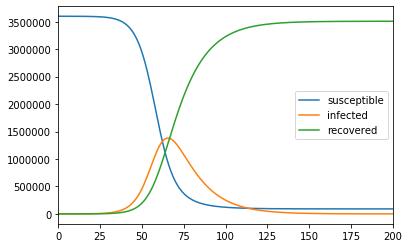

In [3]:
i_0 = 100
s, i, r = 3600000, i_0, 0
doubling_time = 4.0
recovery_days = 14.0
intrinsic_growth_rate = 2**(1/float(doubling_time)) - 1
gamma = 1/recovery_days
beta = (intrinsic_growth_rate+gamma)/s
n_days = 200

sim_df = pd.DataFrame(data=gen_sir(s, i, r, beta, gamma, n_days),
            columns = ("day", "susceptible", "infected", "recovered"))
sim_df[["susceptible","infected", "recovered"]].plot()

- Recovered -> ~ population size at end of epidemic (eg. almost everyone gets infected eventually)

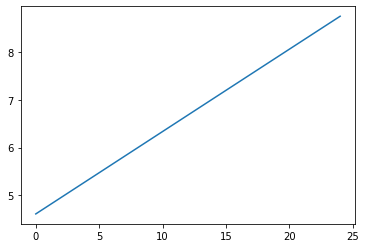

In [4]:
# Fits exponential growth early on
fig, ax = plt.subplots(1,1)
ax.plot(np.log(sim_df['infected'].head(25)))

# SIR extension 1 - Pair-approximation
>Pair approximation methods (Keeling 1999) are based on a differential
equation model of counting the number of pairs of
individuals in each disease class. These methods are
particularly useful for networks with clustering or
spatial networks. 

![image.png](https://user-images.githubusercontent.com/1396669/78389710-352ca180-75b1-11ea-9f05-bf7066ff4dc9.png)

In [5]:
def sir_keeling(
    s: float, i: float, r: float, si: float, ss: float, alpha: float, beta: float, gamma: float, n: float
) -> Tuple[float, float, float]:
    """The SIR model, one time step."""
    s_n = (-beta * si) + s
    i_n = (beta * si - gamma * i) + i
    si_n = (((beta * si) / (s)) * ( ((alpha-1) * ss) - ((alpha-1) * si) - alpha*s ) - gamma * si) + si
    ss_n = (-2 * ((beta * si) / (s)) * (alpha - 1) * ss) + ss
    r_n = gamma * i + r
    if s_n < 0.0:
        s_n = 0.0
    if i_n < 0.0:
        i_n = 0.0
    if r_n < 0.0:
        r_n = 0.0

    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale, si_n, ss_n


def gen_sir_keeling(
    s: float, i: float, r: float, si: float, ss: float, alpha: float, beta: float, gamma: float, n_days: int,
):
    """Simulate SIR model forward in time yielding tuples."""
    s, i, r, si, ss = (float(v) for v in (s, i, r, si, ss))
    n = s + i + r
    for d in range(n_days + 1):
        yield d, s, i, r, si, ss
        s, i, r, si, ss = sir_keeling(s, i, r, si, ss, alpha, beta, gamma, n)


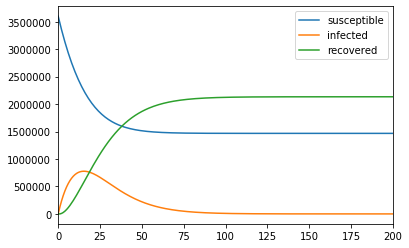

In [6]:
i_0 = 100
s, i, r, si, ss = 3600000, i_0, 0, i_0*1000, 10
alpha = 0.01
doubling_time = 4.0
recovery_days = 14.0
intrinsic_growth_rate = 2**(1/float(doubling_time)) - 1
gamma = 1/recovery_days
beta = 1 + (intrinsic_growth_rate+gamma)
n_days = 200

sim_df = pd.DataFrame(data=gen_sir_keeling(s, i, r, si, ss, alpha, beta, gamma, n_days),
            columns = ("day", "susceptible", "infected", "recovered", "si", "ss"))
sim_df[["susceptible","infected", "recovered"]].plot()

- Recovered << population size at end of epidemic
- Earlier, smaller peak and shorter exponential phase

# SIR extension 2 - Power-law modification

> Stroud et al. (2006) modify the term representing the proportion of susceptibles in the homogeneous mixing model with an empirical exponent $S/N^\nu$, where $\nu$ is estimated from simulation data.

![image.png](https://user-images.githubusercontent.com/1396669/78389751-4bd2f880-75b1-11ea-8283-fc5bc9461eac.png)

In [21]:
def sir_stroud(
    s: float, i: float, r: float, beta: float, nu: float, gamma: float, n: float
) -> Tuple[float, float, float]:
    """The SIR model, one time step."""
    s_n = (-beta) * (s/n)**nu * i + s
    i_n = (beta * (s/n)**nu * i  - gamma * i) + i
    r_n = gamma * i + r
    if s_n < 0.0:
        s_n = 0.0
    if i_n < 0.0:
        i_n = 0.0
    if r_n < 0.0:
        r_n = 0.0

    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale


def gen_sir_stroud(
    s: float, i: float, r: float, beta: float, nu: float, gamma: float, n_days: int,
):
    """Simulate SIR model forward in time yielding tuples."""
    s, i, r = (float(v) for v in (s, i, r))
    n = s + i + r
    for d in range(n_days + 1):
        yield d, s, i, r
        s, i, r = sir_stroud(s, i, r, beta, nu, gamma, n)

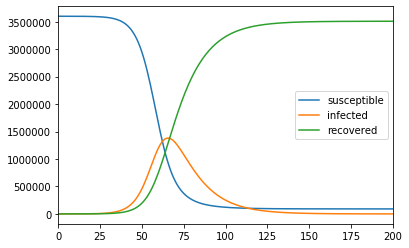

In [39]:
i_0 = 100
s, i, r = 3600000, i_0, 0
doubling_time = 4.0
recovery_days = 14.0
intrinsic_growth_rate = 2**(1/float(doubling_time)) - 1
gamma = 1/recovery_days
beta = (intrinsic_growth_rate+gamma)
nu = 1.0
n_days = 200

sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
            columns = ("day", "susceptible", "infected", "recovered"))
sim_df[["susceptible","infected", "recovered"]].plot()

In [40]:
sim_df['infected'].head(50)

0        100.000000
1        118.919988
2        141.419410
3        168.175361
4        199.992974
5        237.829626
6        282.823692
7        336.328743
8        399.954172
9        475.613487
10       565.581683
11       672.563405
12       799.773912
13       951.035219
14      1130.890243
15      1344.738262
16      1598.995630
17      1901.286341
18      2260.667893
19      2687.898777
20      3195.755059
21      3799.404673
22      4516.849482
23      5369.446650
24      6382.522582
25      7586.094445
26      9015.716153
27     10713.467450
28     12729.106337
29     15121.406148
30     17959.698888
31     21325.645286
32     25315.248751
33     30041.123897
34     35635.019086
35     42250.574538
36     50066.270464
37     59288.480130
38     70154.486908
39     82935.247837
40     97937.584484
41    115505.351285
42    136018.970679
43    159892.536796
44    187567.487555
45    219501.655083
46    256152.373193
47    297952.321213
48    345277.018461
49    398403.479337


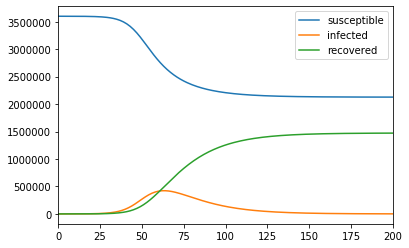

In [37]:
nu = 4.5
n_days = 200

sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
            columns = ("day", "susceptible", "infected", "recovered"))
sim_df[["susceptible","infected", "recovered"]].plot()

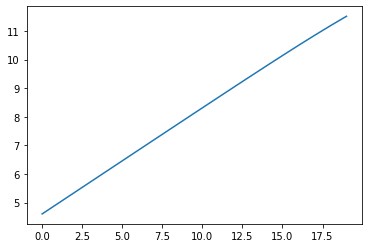

In [10]:
# Fits exponential growth early on
fig, ax = plt.subplots(1,1)
ax.plot(np.log(sim_df['infected'].head(20)))

# Non-exaustive list of outstanding questions
- Can we fit these models to data we have so far
    - If so, will they be distinguisible given the early stage?
- Effect of distancing will be different (stonger?) in models containing/accounting for contact structure
- These extensions assume particular network structures (degree distributions). Bansal et al find exponentially destirbuted degree-distributions to fit several real-world datasets best..
- How do we message the implication that (conditional on input parameters), CHIME will give the _most pessimistic_ estimate of epidemic size and peak demand?